In [1]:
!pip install ftfy regex tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00


In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9_iugk2s
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-9_iugk2s
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [34]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import seaborn as sns
from google.colab import drive
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


# Load Pre-trained CLIP models

In [5]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [6]:
model, preprocess = clip.load("ViT-L/14")
input_image_size = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_image_size)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 890M/890M [02:18<00:00, 6.75MiB/s]


Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49408


In [10]:
# Define the custom classes
classes = [
    "dog", "cat", "bird", "car",
    "bicycle", "boat", "pizza", "burger",
    "mountain", "beach", "forest", "city",
    "laptop", "phone", "airplane", "flower"
]

# Input Image

In [16]:
# Process from Image encoder CLIP
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7b9f5deb8400>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [36]:
def load_and_preprocess_images(image_folder):
    images = []
    image_names = []
    original_images = []

    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            image_path = os.path.join(image_folder, filename)
            try:
                # Original image for visualization
                original_img = Image.open(image_path)

                # Show the image immediately after reading
                plt.figure(figsize=(5, 5))
                plt.imshow(original_img)
                plt.title(f"Loaded Image: {filename}")
                plt.axis('off')
                plt.show()

                original_images.append(original_img)

                # Preprocessed image for CLIP
                image = preprocess(original_img).unsqueeze(0).to(device)
                images.append(image)
                image_names.append(filename)
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    return torch.cat(images), image_names, original_images

In [37]:
IMAGE_FOLDER = '/content/drive/MyDrive/Images'

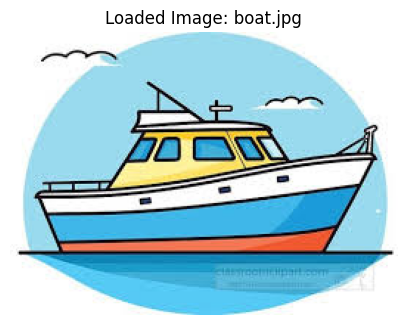

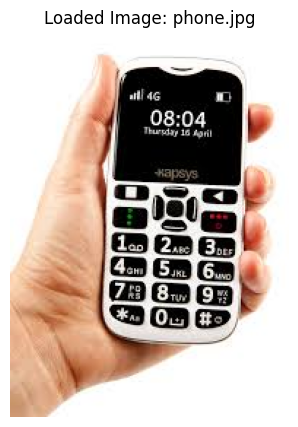

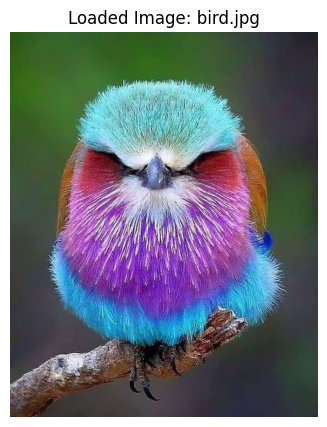

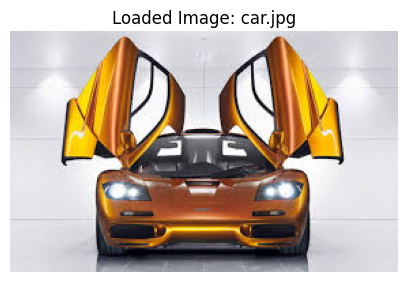

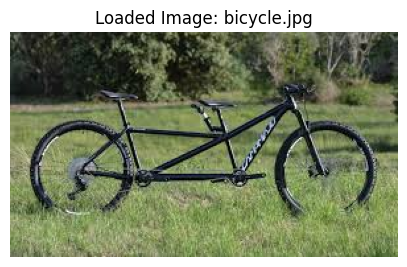

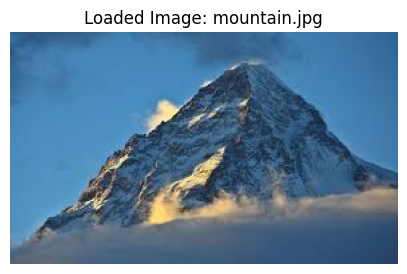

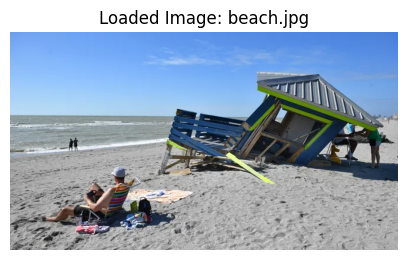

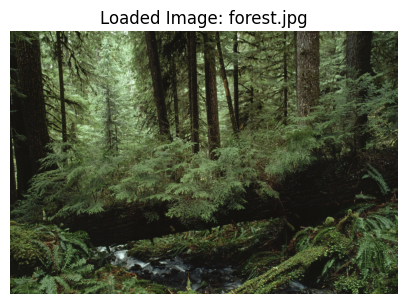

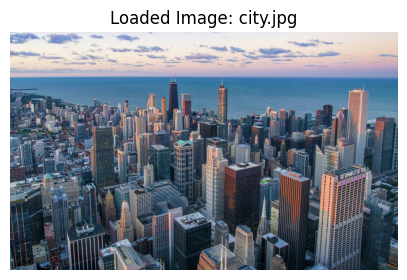

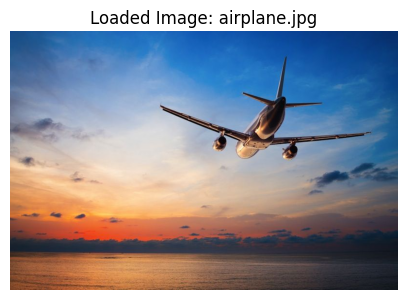

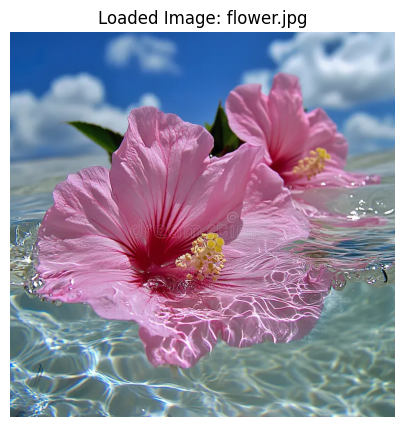

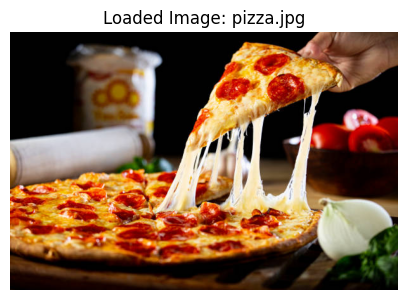

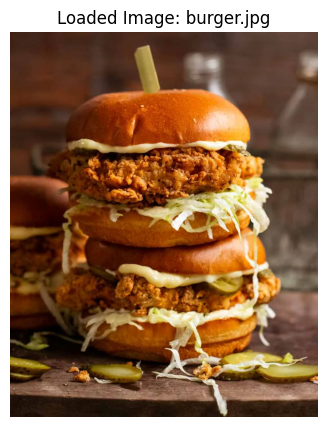

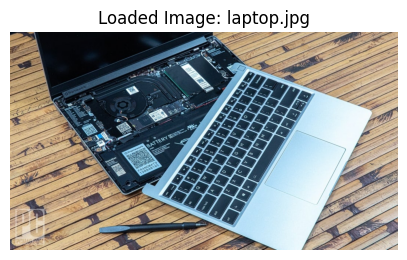

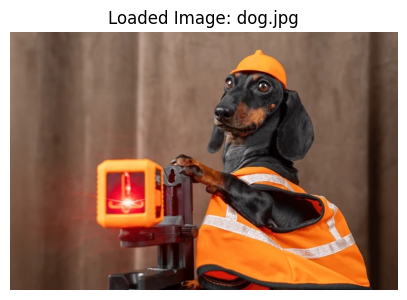

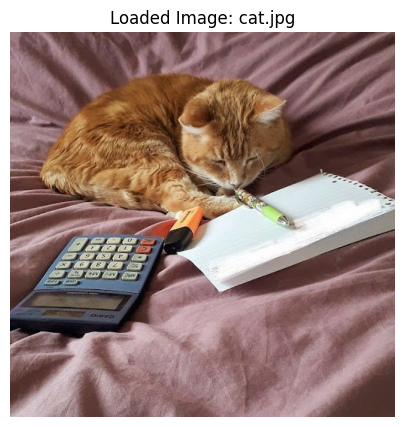

In [38]:
# Load and preprocess images
images, image_names, original_images = load_and_preprocess_images(IMAGE_FOLDER)

# Input Text

In [18]:
clip.tokenize

<function clip.clip.tokenize(texts: Union[str, List[str]], context_length: int = 77, truncate: bool = False) -> Union[torch.IntTensor, torch.LongTensor]>

In [32]:
# Prepare text descriptions
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

# Prediction

In [20]:
# Perform zero-shot classification
with torch.no_grad():
    image_features = model.encode_image(images)
    text_features = model.encode_text(text_inputs)

    # Normalize features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute similarity
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# Visualization

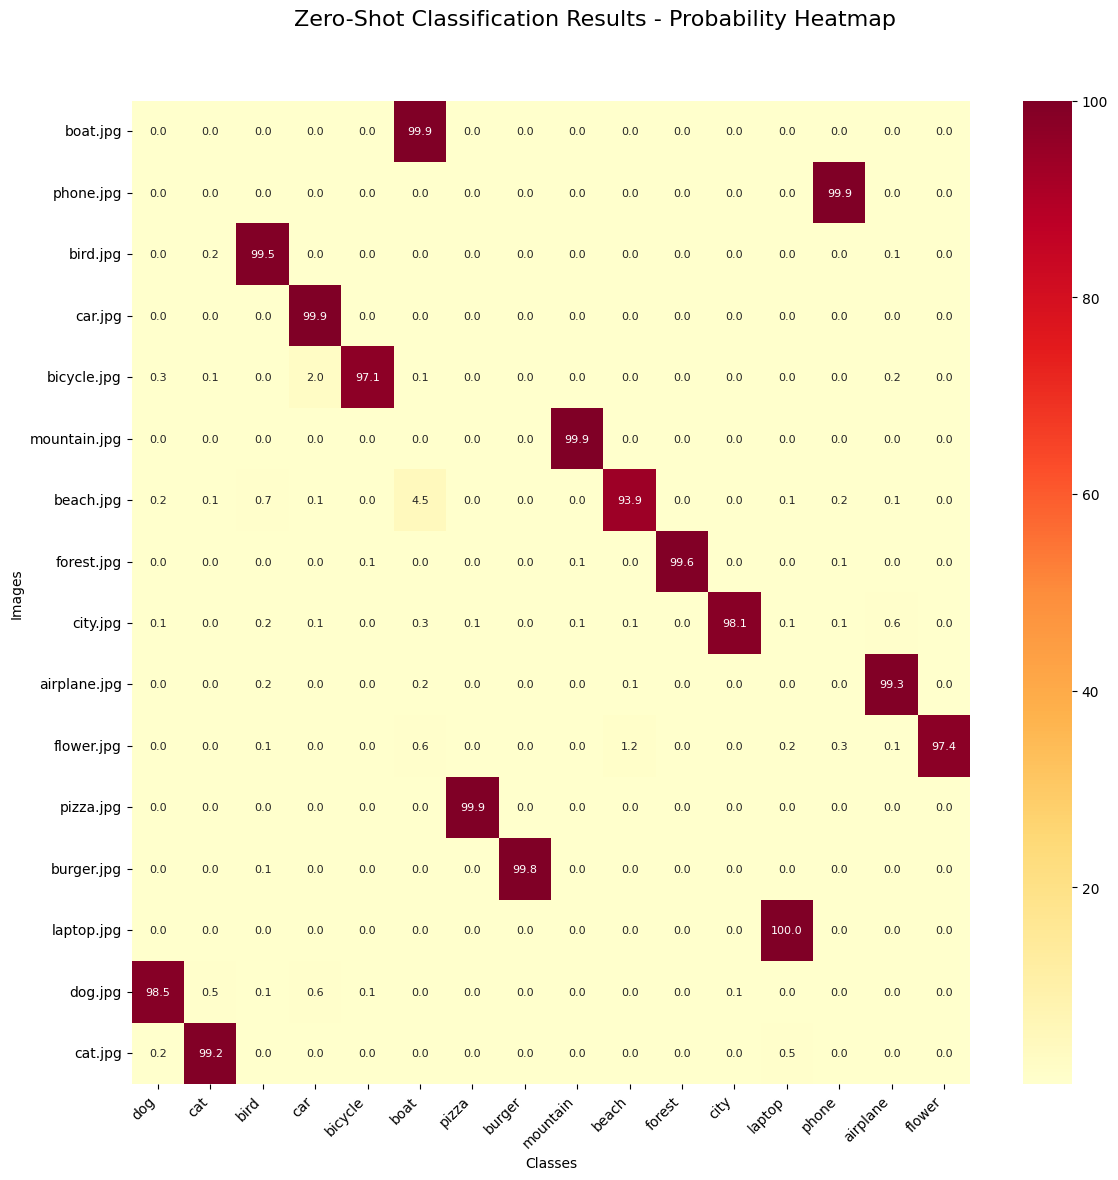

In [41]:
# Visualization of classification results using heatmap
plt.figure(figsize=(12, 12))
plt.suptitle("Zero-Shot Classification Results - Probability Heatmap", fontsize=16)

# Convert similarity scores to numpy array for visualization
similarity_np = similarity.cpu().numpy() * 100

# Create heatmap
sns.heatmap(
    similarity_np,
    xticklabels=classes,
    yticklabels=image_names,
    cmap='YlOrRd',
    annot=True,
    fmt='.1f',
    annot_kws={'size': 8}
)

plt.xlabel('Classes')
plt.ylabel('Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

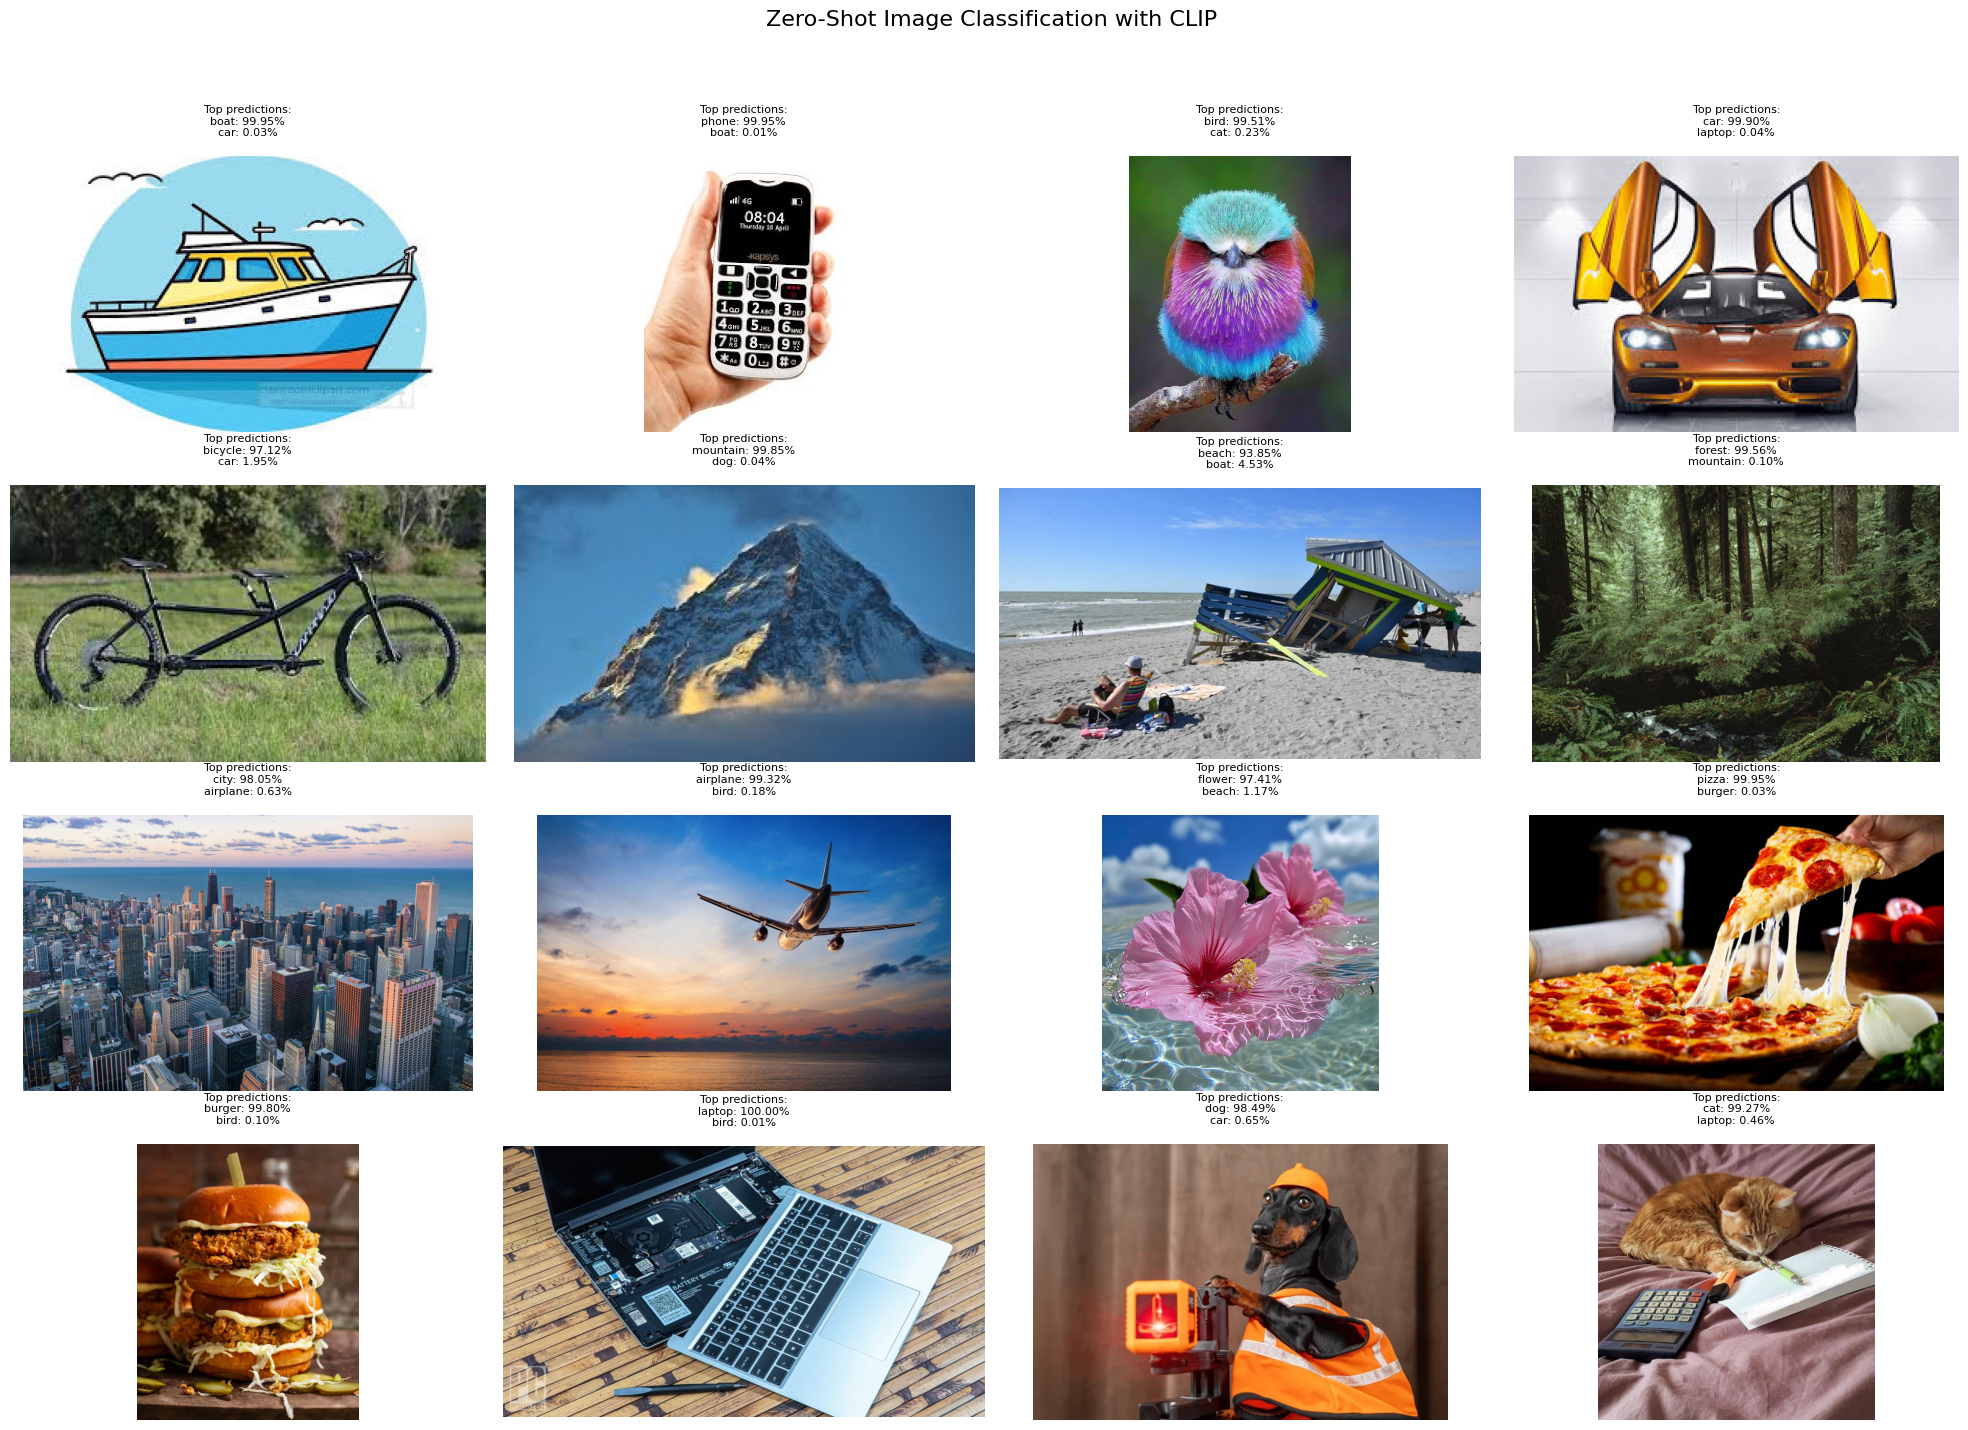

In [23]:
plt.figure(figsize=(20, 15))
plt.suptitle("Zero-Shot Image Classification with CLIP", fontsize=16)

for i in range(len(images)):
    plt.subplot(4, 4, i+1)

    # Load original image for display
    original_image = Image.open(os.path.join(IMAGE_FOLDER, image_names[i]))
    plt.imshow(original_image)

    # Get probabilities for this image
    probs = similarity[i]

    # Add classification results as title
    top_probs, top_labels = probs.topk(3)
    title = f"Top predictions:\n"
    for j in range(2):
        title += f"{classes[top_labels[j]]}: {top_probs[j].item()*100:.2f}%\n"

    plt.title(title, fontsize=8)
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()